In [1]:
from marketsai.mon_policy.env_mon_policy_finite_dict import MonPolicyFinite

# import scipy.io as sio
# from scipy.interpolate import RegularGridInterpolator
from scipy.stats import linregress
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import random


# from sklearn import linear_model
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init

""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = False  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_HIST = True
PLOT_PROGRESS = False  # create plot with progress
SIMUL_EPISODES = 30
NO_FLEX_HORIZON = 32
ENV_HORIZON = 72
BETA = 0.95 ** (1 / 12)

# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)

# Input Directories (of json file with experiment data)
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_mon_fin_dict_exp_0_Oct26_PPO_run.json"


# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/ALL/"
    )

# Output Directories
# if FOR_PUBLIC:
#     OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
#     OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
#     OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"
#     OUTPUT_PATH_TABLES = (
#         "/scratch/mc5851/ray_results/Tables/"
#     )
# else:
#     OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
#     OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
#     OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"
#     OUTPUT_PATH_TABLES = (
#         "/scratch/mc5851/ray_results/Tables/ALL/"
#     )

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)

""" Step 0: import experiment data and initalize empty output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)

print(exp_data_dict["exp_names"][0])

# UNPACK USEFUL DATA
num_trials = len(exp_data_dict["results_eval"][0])
exp_names = exp_data_dict["exp_names"][0]
checkpoints = exp_data_dict["checkpoints"][0]

INPUT_PATH_CHECKPOINT = checkpoints[3]

# progress_csv_dirs = exp_data_dict["progress_csv_dirs"]


# best_rewards = exp_data_dict["best_rewards"]

# useful functions
def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]



        

native_mon_fin_dict_exp_0_Oct26_PPO_run


In [ ]:
results = {
    "Profits": exp_data_dict["results_eval"][6],
    "Markups": exp_data_dict["results_eval"][1],
    "Freq. of Adj.": exp_data_dict["results_eval"][3],
    "Size of Adj.": exp_data_dict["results_eval"][4],
}

results_stats = {
    "Mean Profits": np.mean(results["Profits"]),
    "S.D. Profits": np.std(results["Profits"]),
    "Mean Markups": np.mean(results["Markups"]),
    "S.D. Markups": np.std(results["Markups"]),
    "Mean Freq. of Adj.": np.mean(results["Freq. of Adj."]),
    "S.D. Freq. of Adj.": np.std(results["Freq. of Adj."]),
    "Mean Size of Adj.": np.mean(results["Size of Adj."]),
    "S.D. Size of Adj.": np.std(results["Size of Adj."]),
}

print(results_stats)
#Create statistics table

print(results)
if PLOT_HIST:
    for i, x in results.items():
        plt.hist(x)
        plt.title(i)
        plt.savefig(
            OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + exp_names[0] + ".jpg"
        )
        plt.show()
        plt.close()

In [ ]:
""" Step 1: Plot progress during learning run """

if PLOT_PROGRESS == True:
    # Big plot

    data_progress_df = pd.read_csv(progress_csv_dirs[0])
    max_rewards = abs(data_progress_df["discounted_rewards_trial_0"].max())
    exp_data_simul_dict["max rewards"].append(max_rewards)
    exp_data_simul_dict["time to peak"].append(0)

    for metric in [
        "discounted_rewards",
        "mu_ij_mean",
        "freq_p_adj_mean",
        "size_adj_mean",
    ]:
        for trial_metric in [
            metric + f"_trial_{i}" for i in range(len(results["discounted_rewards"]))
        ]:
            learning_plot = sn.lineplot(
                data=data_progress_df, y=trial_metric, x="episodes_total"
            )

        learning_plot = learning_plot.get_figure()
        plt.ylabel(metric)
        plt.xlabel("Timesteps (thousands)")
        plt.xlim([0, 500])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_" + metric + "_" + exp_names[-1] + ".png"
        )
        plt.show()
        plt.close()

In [2]:

""" Step 2: Congif env, Restore RL policy """

""" Step 2.0: replicate original environemnt and config """
# environment config
env_config_eval = {
    "horizon": ENV_HORIZON,
    "n_inds": 200,
    "n_firms": 2,
    "eval_mode": True,
    "random_eval": False,
    "analysis_mode": False,
    "noagg": False,
    "obs_flex_index": True,
    "regime_change": False,
    "infl_regime": "low",
    # "infl_regime_scale": [3, 1.3, 2],
    # "infl_transprob": [[23 / 24, 1 / 24], [1 / 24, 23 / 24]],
    # "seed_eval": 10000,
    # "seed_analisys": 3000,
    # "markup_min": 1,
    # "markup_max": 2,
    # "markup_star": 1.3,
    # "final_stage": 12,
    # "rew_mean": 0,
    # "rew_std": 1,
    # "parameters": {
    #     "beta": 0.95 ** (1 / 12),
    #     "log_g_bar": 0.0021,
    #     "rho_g": 0.61,
    #     "sigma_g": 0.0019,
    #     "theta": 1.5,
    #     "eta": 10.5,
    #     "menu_cost": 0.17,
    #     "sigma_z": 0.038,
    # },
}



env_config_noagg = env_config_eval.copy()
env_config_noagg["no_agg"] = True


# We instantiate the environment to extract information.
env = MonPolicyFinite(env_config_eval)
config_algo = {
    "gamma": BETA,
    "env": env_label,
    "env_config": env_config_eval,
    "horizon": ENV_HORIZON,
    "explore": False,
    "framework": "torch",
    "multiagent": {
        "policies": {
            "firm_even": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
            "firm_odd": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
        },
        "policy_mapping_fn": (
            lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
        ),
    },
}




/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
""" Step 3.0: replicate original environemnt and config """
shutdown()
init(
    num_cpus = 12,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicyFinite)
# We instantiate the environment to extract information.
""" CHANGE HERE """
env = MonPolicyFinite(env_config_eval)
env_noagg = MonPolicyFinite(env_config_noagg)

""" Step 3.1: restore trainer """



# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
mu_ij_final_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []

log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
log_c_list_noagg = []

log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []

# loop with agg
obs = env.reset()
obs_noagg = env_noagg.reset()
for t in range(SIMUL_EPISODES*ENV_HORIZON):
    if t % env.horizon == 0:
        seed = random.randrange(100000)
        env.seed_eval = seed
        env_noagg.seed_eval = seed
        print("time:", t)
        obs = env.reset()
        obs_noagg = env_noagg.reset()
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(obs_noagg[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_noagg[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)

    if t % env.horizon < NO_FLEX_HORIZON:
        profits_list.append(info[0]["mean_profits"])
        mu_ij_list.append(info[0]["mean_mu_ij"])
        freq_p_adj_list.append(info[0]["move_freq"])
        freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
        freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
        size_adj_list.append(info[0]["mean_p_change"])
        size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
        size_adj_highmu_list.append(info[0]["size_adj_highmu"])
        log_c_list.append(info[0]["log_c"])
        epsilon_g_list.append(env.epsilon_g)
        profits_list_noagg.append(info_noagg[0]["mean_profits"])
        mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
        freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
        freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
        freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
        size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
        size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
        size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
        log_c_list_noagg.append(info_noagg[0]["log_c"])
        log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
        freq_adj_lowmu_filt_list.append(freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1])
        freq_adj_highmu_filt_list.append(freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1])
        size_adj_lowmu_filt_list.append(size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1])
        size_adj_highmu_filt_list.append(size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1])
    if t % env.horizon > env.horizon+1-env.final_stage:
        mu_ij_final_list.append(info[0]["mean_mu_ij"])

print(len(profits_list))

shutdown()

2021-10-27 21:05:10,462	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-27 21:05:12,997	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-27 21:05:18,060	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_mon_fin_dict_exp_0_Oct26_PPO_run/PPO_mon_fin_dict_0bfe1_00003_3_2021-10-26_21-05-59/checkpoint_002000/checkpoint-2000
2021-10-27 21:05:18,063	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 2000, '_timesteps_total': None, '_time_total': 37166.599007606506, '_episodes_total': 4000}


time: 0
time: 72
time: 144
time: 216
time: 288
time: 360
time: 432
time: 504
time: 576
time: 648
time: 720
time: 792
time: 864
time: 936
time: 1008
720


[[1.         0.59629794]
 [0.59629794 1.        ]] 0.009324449292798217 0.005964042622180018


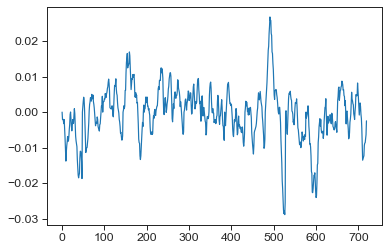

705 705
690 690
675 675
660 660
645 645
630 630
615 615
600 600
585 585
570 570
555 555
540 540
525 525
{'Mean Profits': [0.08966761430666123], 'S.D. Profits': [0.007567089796169972], 'Max Profits': [0.10757706276164644], 'Min Profits': [0.06508266124632398], 'Mean Markups': [1.3107870586185113], 'S.D. Markups': [0.011961127134394614], 'Max Markups': [1.3468764079219144], 'Min Markups': [1.2776044225276646], 'Mean Freq. of Adj.': [0.11934027777777777], 'S.D. Freq. of Adj.': [0.02148922960023761], 'Max Freq. of Adj.': [0.185], 'Min Freq. of Adj.': [0.0575], 'Mean Size of Adj.': [0.08028408214698222], 'S.D. Size of Adj.': [0.011225799264486701], 'Max Size of Adj.': [0.12221459162251909], 'Min Size of Adj.': [0.05224756686903743], 'S.D. log C': [0.00749621352569212], 'Mean Flex. Markup': [1.2273267860477168], 'IRs': [[0.8103076305128217, 0.3371953063505954, 0.1386622088657586, -0.01625750796813905, -0.03861889511633775, -0.08564254254018791, -0.07467206350644827, -0.1280871388402941, -0.0

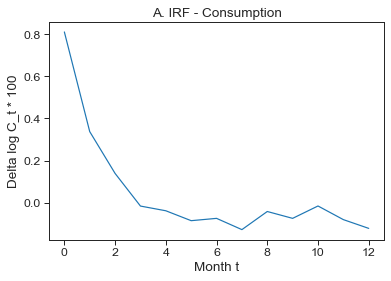

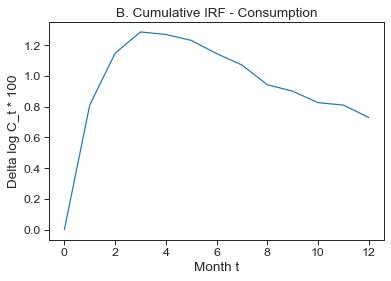

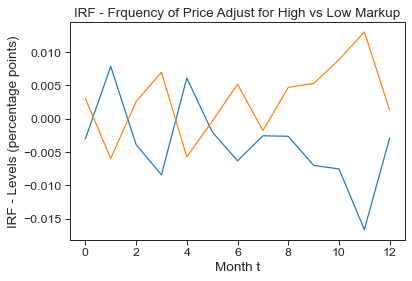

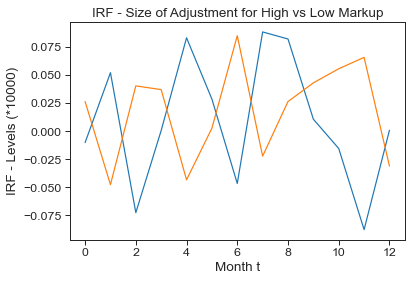

In [4]:
simul_results_dict = {
    "Mean Profits": [],
    "S.D. Profits": [],
    "Max Profits": [],
    "Min Profits": [],
    "Mean Markups": [],
    "S.D. Markups": [],
    "Max Markups": [],
    "Min Markups": [],
    "Mean Freq. of Adj.": [],
    "S.D. Freq. of Adj.": [],
    "Max Freq. of Adj.": [],
    "Min Freq. of Adj.": [],
    "Mean Size of Adj.": [],
    "S.D. Size of Adj.": [],
    "Max Size of Adj.": [],
    "Min Size of Adj.": [],
    "S.D. log C": [],
    "Mean Flex. Markup": [],
    "IRs": [],
    "cum_IRs": []}
epsilon_g_pereps = [epsilon_g_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
log_c_filt_pereps = [log_c_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
freq_adj_lowmu_pereps = [freq_adj_lowmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
freq_adj_highmu_pereps = [freq_adj_highmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
size_adj_lowmu_pereps = [size_adj_lowmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
size_adj_highmu_pereps = [size_adj_highmu_filt_list[i*NO_FLEX_HORIZON:i*NO_FLEX_HORIZON+NO_FLEX_HORIZON] for i in range(SIMUL_EPISODES)]
delta_log_c_pereps = [[j - i for i, j in zip(log_c_filt_pereps[k][:-1], log_c_filt_pereps[k][1:])] for k in range(SIMUL_EPISODES) ]
# print("log_c_filt:", log_c_filt_list, "\n",
#     #"delta_log_c:", delta_log_c, 
#     "\n"
print(np.corrcoef(log_c_list, log_c_list_noagg), np.std(log_c_list), np.std(log_c_list_noagg) )
plt.plot(log_c_filt_list)
plt.show()
plt.close()

IRs = [0 for t in range(13)]
IRs_freqlow = [0 for t in range(13)]
IRs_freqhigh = [0 for t in range(13)]
IRs_sizelow = [0 for t in range(13)]
IRs_sizehigh = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_pereps_reg = [epsilon_g_pereps[i][: -(t + 1)] for i in range(SIMUL_EPISODES)]
    delta_log_c_pereps_reg = [delta_log_c_pereps[i][t:]  for i in range(SIMUL_EPISODES)]
    freq_adj_lowmu_pereps_reg = [freq_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    freq_adj_highmu_pereps_reg = [freq_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    size_adj_lowmu_pereps_reg = [size_adj_lowmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    size_adj_highmu_pereps_reg = [size_adj_highmu_pereps[i][t:] for i in range(SIMUL_EPISODES)]
    epsilon_g_reg = [item for sublist in epsilon_g_pereps_reg for item in sublist]
    delta_log_c_reg = [item for sublist in delta_log_c_pereps_reg for item in sublist]
    freq_adj_lowmu_reg = [item for sublist in freq_adj_lowmu_pereps_reg for item in sublist]
    freq_adj_highmu_reg = [item for sublist in freq_adj_highmu_pereps_reg for item in sublist]
    size_adj_lowmu_reg = [item for sublist in size_adj_lowmu_pereps_reg for item in sublist]
    size_adj_highmu_reg = [item for sublist in size_adj_highmu_pereps_reg for item in sublist]
    print(len(epsilon_g_reg), len(delta_log_c_reg))
    epsilon_g_reg_filt = [i for i in epsilon_g_reg if i>0] 
    delta_log_c_reg_filt = [delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0]
    freq_adj_lowmu_reg_filt = [freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    freq_adj_highmu_reg_filt = [freq_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    size_adj_lowmu_reg_filt = [size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0] 
    size_adj_highmu_reg_filt = [size_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0]  

    # regressions
    reg_c = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg_c[0] * env.params["sigma_g"] 
    reg_freqlow = linregress(freq_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqlow[t] = reg_freqlow[0] * env.params["sigma_g"]
    reg_freqhigh = linregress(freq_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqhigh[t] = reg_freqhigh[0] * env.params["sigma_g"]
    reg_sizelow = linregress(size_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizelow[t] = reg_sizelow[0] * env.params["sigma_g"]
    reg_sizehigh = linregress(size_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizehigh[t] = reg_sizehigh[0] * env.params["sigma_g"]
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]



simul_results_dict["Mean Profits"].append(np.mean(profits_list))
simul_results_dict["S.D. Profits"].append(np.std(profits_list))
simul_results_dict["Max Profits"].append(np.max(profits_list))
simul_results_dict["Min Profits"].append(np.min(profits_list))
simul_results_dict["Mean Markups"].append(np.mean(mu_ij_list))
simul_results_dict["S.D. Markups"].append(np.std(mu_ij_list))
simul_results_dict["Max Markups"].append(np.max(mu_ij_list))
simul_results_dict["Min Markups"].append(np.min(mu_ij_list))
simul_results_dict["Mean Freq. of Adj."].append(np.mean(freq_p_adj_list))
simul_results_dict["S.D. Freq. of Adj."].append(np.std(freq_p_adj_list))
simul_results_dict["Max Freq. of Adj."].append(np.max(freq_p_adj_list))
simul_results_dict["Min Freq. of Adj."].append(np.min(freq_p_adj_list))
simul_results_dict["Mean Size of Adj."].append(np.mean(size_adj_list))
simul_results_dict["S.D. Size of Adj."].append(np.std(size_adj_list))
simul_results_dict["Max Size of Adj."].append(np.max(size_adj_list))
simul_results_dict["Min Size of Adj."].append(np.min(size_adj_list))
simul_results_dict["S.D. log C"].append(np.std(log_c_filt_list))
simul_results_dict["Mean Flex. Markup"].append(np.mean(mu_ij_final_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)
# simul_results_dict["IRs_freqlow"].append(IRs_freqlow)
# simul_results_dict["IRs_freqhigh"].append(IRs_freqhigh)
# simul_results_dict["IRs_sizelow"].append(IRs_sizelow)
# simul_results_dict["IRs_sizehigh"].append(IRs_sizehigh)

print(simul_results_dict)
print(
    "std_log_c:",
    simul_results_dict["S.D. log C"],
    "\n" + "mu_ij:",
    simul_results_dict["Mean Markups"],
    "\n" + "freq_p_adj:",
    simul_results_dict["Mean Freq. of Adj."],
    "\n" + "size_adj:",
    simul_results_dict["Mean Size of Adj."],
    "\n" + "mu_ij_final:",
    simul_results_dict["Mean Flex. Markup"],
)

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

cum_IRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("B. Cumulative IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()


plt.plot(x, IRs_freqlow)
plt.plot(x, IRs_freqhigh)
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (percentage points)")
plt.xlabel("Month t")
plt.title("IRF - Frquency of Price Adjust for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_sizelow)
plt.plot(x, IRs_sizehigh)
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels (*10000)")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq" + exp_names[0] + "finite_first" + ".png")
plt.show()
plt.close()




In [ ]:
""" Step 8 and final: Table with moments """
exp_table_df = pd.DataFrame.from_dict(simul_results_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

# exp_table_small_df=exp_table_df[["n_industries", "Discounted Rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_SMALL_TABLE.tex','w') as tf:
#     tf.write(exp_table_small_df.to_latex())